In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import glob, os, re, random

from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from itertools import groupby
from operator import itemgetter


from fuzzywuzzy import  fuzz, process

from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import cross_validation, metrics   #model optimization and valuation tools
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,printFeatureImportance=True,cv_folds=5):
    """
    This functions train the model given as 'alg' by performing cross-validation. It works on both regression and classification
    alg: sklearn model
    dtrain: pandas.DataFrame, training set
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    scoring_method: str, method to be used by the cross-validation to valuate the model
    performCV: bool, perform Cv or not
    printFeatureImportance: bool, plot histogram of features importance or not
    cv_folds: int, degree of cross-validation
    """
    # train the algorithm on data
    alg.fit(dtrain[predictors],dtrain[target])
    #predict on train set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #perform cross-validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        #print model report
        print "\nModel report:"
        if scoring_method == 'roc_auc':
            print "Accuracy:",metrics.accuracy_score(dtrain[target].values,dtrain_predictions)
            print "AUC Score (Train):",metrics.roc_auc_score(dtrain[target], dtrain_predprob)
        if (scoring_method == 'mean_squared_error'):
            print "Accuracy:",metrics.mean_squared_error(dtrain[target].values,dtrain_predictions)
    if performCV:
        print "CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    #print feature importance
    if printFeatureImportance:
        if dir(alg)[0] == '_Booster': #runs only if alg is xgboost
            feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        else:
            feat_imp = pd.Series(alg.feature_importances_,predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar',title='Feature Importances')
        plt.ylabel('Feature Importe Score')
        plt.show()
    return alg

def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    """
    This functions is used to tune paremeters of a predictive algorithm
    alg: sklearn model,
    param_test: dict, parameters to be tuned
    scoring_method: str, method to be used by the cross-validation to valuate the model
    train: pandas.DataFrame, training data
    predictors: list, labels to be used in the model training process. They should be in the column names of dtrain
    target: str, target variable
    """
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring=scoring_method,n_jobs=2,iid=False,cv=5)
    gsearch.fit(train[predictors],train[target])
    return gsearch

# plot optimization results
def plot_opt_results(alg):
    cv_results = []
    for i in range(len(param_test['n_estimators'])):
        cv_results.append((alg.grid_scores_[i][1],alg.grid_scores_[i][0]['n_estimators']))
    cv_results = pd.DataFrame(cv_results)
    plt.plot(cv_results[1],cv_results[0])
    plt.xlabel('# trees')
    plt.ylabel('score')
    plt.title('optimization report')

def clean_text(txt,stop_words):
    wnl = WordNetLemmatizer()
    psm = PorterStemmer()
    # make sure in put is of type str
    if type(txt) is not str:
        txt = str(txt)
    #lower case
    txt = txt.lower()
    #remove non-alphabetic characters
    txt = re.sub("[^\s\w]"," ",txt).split(" ")
    #txt = [str(psm.stem(wnl.lemmatize(w.strip()))) for w in txt]
    #remove stop words
    txt = filter(lambda w:not (w in stop_words),txt)
    txt = ' '.join(txt)
    return txt

After a conversation with a friend experienced in medical science, she pointed out that there is a combination that can weaken a patient and sometimes triggering symptoms of diabetes mellitus. In this notebook, I am going to text mine medications with the goal to find combinations that let to diabetes in the data.

The process consists in:

Part I: Outsource data from webmed

1. Scrape the [page of medications](http://www.webmd.com/drugs/condition-594-Type+2+Diabetes+Mellitus.aspx?diseaseid=594&diseasename=Type+2+Diabetes+Mellitus&source=2&sortColumn=1&sortDirection=a)  that were prescribe to diabetes patients. This page contains reviews from patients about the effects of those medications
2. Clean the scrapped data and build a reference dictionary

Part II: Current Data

1. Convert medication names into document. Each document will be a list of words
2. Build a vocabulary: This is hash table of all unique terms found in all documents
3. Calculate how important each term is for each document. We will use [tf-idf](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
4. Remove noisy terms. Noisy terms are those with high tf-idf in as many document as possible. Keeping in mind that the tfidf is value between 0 and 1, we can sum tf-idfs for each term in all document and set thresholds accordingly. Noisy terms will be added to the list of stop_words
5. With the right vocabulary in hands (initial vocabulary without noisy terms), we will build a binary table with index being PatientHuid and Columns being terms in the dictionary. Each cell value will be 1 if the term has been part of medications ever prescribed to the patient of interest.
6. compare terms in Part I to terms in Part II


Resources:
- http://www.webmd.com/drugs/condition-594-Type+2+Diabetes+Mellitus.aspx?diseaseid=594&diseasename=Type+2+Diabetes+Mellitus&source=2&sortColumn=1&sortDirection=a
- http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

### Web scrapping

In [4]:
from bs4 import BeautifulSoup
import requests

url = "http://www.webmd.com/drugs/condition-594-Type+2+Diabetes+Mellitus.aspx?diseaseid=594&diseasename=Type+2+Diabetes+Mellitus&source=2&sortColumn=1&sortDirection=a"
r = requests.get(url)
data = requests.get(url).text
soup = BeautifulSoup(data,"lxml")

table = soup.find('table',attrs={'class':"drug_results_table_fmt"})
scrapped_meds = []
for row in table.findAll("tr"):
    r = str(row.findAll("td")[0].text)
    r = clean_text(r,[])
    scrapped_meds.append(r)
#scrapped_meds = list(set(reduce(lambda x,y:x+y,scrapped_meds)))

stop_words2 = ['100', '120', '200', '25', '30', '50', '60', '70', '75','oral','subcutaneous','mix','inhalation',
               'and','pak','regular','xl','xr']
#corpus = medText.values.tolist()
tf2 = TfidfVectorizer(analyzer='word',min_df=0,stop_words=stop_words2, ngram_range=(1,1))
tf2_matrix = tf2.fit_transform(scrapped_meds)
scrapped_meds_tfidf = pd.DataFrame(tf2_matrix.todense(),
                                 index = scrapped_meds,
                                 columns = sorted(tf2.vocabulary_),)
diabetes_terms = set(scrapped_meds_tfidf.sum().index.tolist())

### Cleaning Medication Names

In [6]:
df0 = pd.read_csv('data/trainingSet/training_SyncPatient.csv')
df0.index = df0.PatientGuid
df0 = df0.drop('PatientGuid',axis=1).sort_index()

df1 = pd.read_csv('data/trainingSet/training_SyncMedication.csv')
df1 = df1[~df1.MedicationName.isnull()]
patient_medication = df1[['PatientGuid','MedicationName']]
patient_medication.MedicationName+=' '
patient_medication = patient_medication.groupby('PatientGuid').sum().sort_index()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**To do**

- remove all characters which are not alphatic
- remove buzz words
- find similarity between words. Some medical terms can be from same family, so I want these to be grouped together

In [17]:
tic = dt.datetime.now()
stop_words1 = [' ','','oral','tablet','capsule','release','topical','extended','nasal','inhalation',
              'with','delayed','coated','enteric','aerosol','spray','metoprotol','solution','cream',
              'sodium','syrup','d','adapter','tab','tabs','10','100','104','disintegrating','acid','intravenous',
             '1000','11','12','120','12d','13','15','150','16','1a','1b','1x','20','200','2011','2012','21',
              '23','24','24d','25','28','30','300','325','3350','35','40','400','50','500','60','600','625',
              '2a','64','650','750','75','80','81','900','acids','and','at','device','di','dr','easy','ii','in',
              'iv','mg','non','of','oil','pack','packet','packets','poly','top','subcutaneous','mix','inhalation',
               'and','pak','regular','xl','xr']
stop_words_ = [' ','',
              'with', '10','100','104',
             '1000','11','12','120','12d','13','15','150','16','1a','1b','1x','20','200','2011','2012','21',
              '23','24','24d','25','28','30','300','325','3350','35','40','400','50','500','60','600','625',
              '2a','64','650','750','75','80','81','900','and','at','ii','in',
              'iv','mg','non','of','poly','top','subcutaneous','mix','inhalation',
               'and','pak','regular','xl','xr']
medText = patient_medication.MedicationName.apply(lambda w:clean_text(w,stop_words1))
corpus = medText.values.tolist()
tf1 = TfidfVectorizer(analyzer='word',min_df=0,stop_words=stop_words1, ngram_range=(1,1))
tf1_matrix = tf1.fit_transform(corpus)
medications_tfidf = pd.DataFrame(tf1_matrix.todense(),
                                 index = patient_medication.index,
                                 columns = sorted(tf1.vocabulary_),)
print "process time:", dt.datetime.now() - tic

process time: 0:00:00.649055


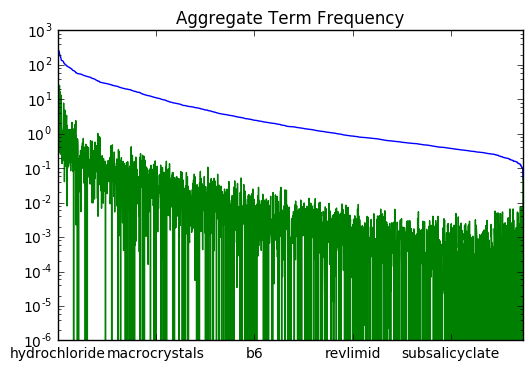

In [18]:
tfidf_agg = medications_tfidf.sum().sort_values(ascending=False)
d_tfidf_agg = -(tfidf_agg - tfidf_agg.shift())#.sort_values()
tfidf_agg.plot()
d_tfidf_agg.plot()
plt.yscale('log')
plt.title("Aggregate Term Frequency")
plt.show()

In [19]:
#stop_words+=tfidf_agg[tfidf_agg>=10].index.tolist()
#medText = patient_medication.MedicationName.apply(lambda w:clean_text(w,stop_words))
#corpus = medText.values.tolist()
#tf = TfidfVectorizer(analyzer='word',min_df=0,stop_words=stop_words, ngram_range=(1,1))
#tfidf_matrix = tf.fit_transform(corpus)
#medications_tfidf = pd.DataFrame(tfidf_matrix.todense(),
#                                 index = patient_medication.index,
#                                 columns = sorted(tf.vocabulary_),)

medications_tfidf['DMIndicator'] = df0.DMIndicator

### Feature Engineering
We use MedicationName available in current medication dataset and cross check it with the set of scrapped meds ever taken by diabetes to find diabetes related medications. These medications will be given higher weight in the modeling part


In [56]:
def get_taken_meds(text,ref_terms=diabetes_terms):
    """
    """
    s1 = set(clean_text(text,stop_words1).split(" "))
    s2 = set(ref_terms)
    r = s1.intersection(s2)
    if len(r) == 0:
        return 'NoMeds'
    else:
        return list(r)

patient_medication['DMIndicator'] = df0.DMIndicator
patient_medication['TakenMeds'] = patient_medication.MedicationName.apply(lambda x:get_taken_meds(x))

In [59]:
patient_medication[patient_medication.TakenMeds != 'NoMeds']


,MedicationName,DMIndicator,TakenMeds
PatientGuid,,,
00B7C61A-82E5-42E1-B9C0-6B39C5BC552F,Dextromethorphan-Promethazine oral syrup Felod...,1,"[welchol, colesevelam]"
0101AC44-80F4-4FF2-9600-322F1C07B38A,Levothyroxine Sodium (levothyroxine) oral tabl...,1,[injection]
0315DDEA-2B3F-49E0-8FD5-FD249A154FE2,Venlafaxine Hydrochloride (venlafaxine) oral t...,1,"[welchol, colesevelam]"
0433679A-2E12-4D82-B184-F7B3461590CA,Rocephin (cefTRIAXone) injectable powder for i...,1,[injection]
05AF6A2B-1A0D-405F-9895-0FE28FF27768,Omeprazole oral enteric coated tablet AmLODIPi...,1,[micronized]
0635CEAA-1B29-4211-A7D7-93D7FBD82491,ClonazePAM oral tablet ZyPREXA (OLANZapine) or...,0,[injection]
08277F24-E58B-4831-9FA4-264618E99598,Losartan Potassium (losartan) oral tablet Acar...,1,[acarbose]
0C8CC3C9-6F93-45B1-A952-509EECE7C762,Mupirocin (mupirocin topical) topical ointment...,0,"[welchol, colesevelam]"
0D697D0C-2444-40B9-B3E0-46BC1B7DD186,CefTRIAXone Sodium (cefTRIAXone) injectable po...,1,[injection]


### Modeling

In [14]:
labels0 = medications_tfidf.columns[:-1]
target = 'DMIndicator'
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(medications_tfidf[labels0],
                                                   medications_tfidf[target],test_size=1/4.,random_state=123)

In [ ]:
#df = medications_tfidf[medications_tfidf.columns[:-1]].sum().sort_values(ascending=False)
#df.plot()
#plt.show()

#labels1 = df[df>=10].index.tolist()
#target = 'DMIndicator'
#_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(medications_tfidf[labels1],
                                                   medications_tfidf[target],test_size=1/4.,random_state=123)

In [ ]:
#mnb = MultinomialNB()
#mnb.fit(_Xtrain,_Ytrain)
#ypred = mnb.predict(_Xvalid)
#print "ROC AUC:", metrics.roc_auc_score(ypred,_Yvalid)